In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
import tensorflow as tf
sns.set()
# to ignore warnings when using Grid Search
filterwarnings(action='ignore',
               message=".*Setting penalty='none' will ignore the C and l1_ratio parameters.*")

In [58]:

df_all = pd.read_csv('data/train.csv')
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
# print count of na values.
column_wise_nans = df_all.isna().sum(0)
percent_of_nans = column_wise_nans / df_all.shape[0] * 100
print(f'Percent of nans in columns: \n\n{percent_of_nans}')


Percent of nans in columns: 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [60]:
# dropping useless labels
df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'],axis=1, inplace=True)

# working with na
df_all.dropna(inplace=True)
# df_all.fillna(df_all.mean())
# df_all.dropna(subset=['Embarked'], inplace=True)

# using one hot encoding for categorical data
df_all = pd.get_dummies(df_all, columns=['Sex', 'Embarked'])

df_all.head()



,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [117]:
df_X = df_all.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_all['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)


In [142]:
# finding best hyper parameters using Grid Search

model = make_pipeline(MinMaxScaler(), LogisticRegression())
param_grid = {'logisticregression__fit_intercept': [True, False],
              'logisticregression__penalty': ['l2', 'none'],
              'logisticregression__C': [0.001, 0.01, 1, 10, 100],
              'logisticregression__max_iter': [1000]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X, y);

In [143]:
print(f'best parameters: {grid.best_params_}')
# score without MinMaxScaler = 0.80, with = 0.779
print(f'model score: {grid.score(X, y)}')

best parameters: {'logisticregression__C': 0.01, 'logisticregression__fit_intercept': True, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}
model score: 0.7794943820224719


In [150]:
print(pd.Series(np.ravel(grid.best_estimator_['logisticregression'].coef_), index=df_X.columns.values))
print(grid.best_estimator_['logisticregression'].intercept_)

Pclass       -0.352486
Age          -0.052472
SibSp        -0.021975
Parch         0.019217
Fare          0.061180
Sex_female    0.489238
Sex_male     -0.489239
Embarked_C    0.143369
Embarked_Q   -0.032840
Embarked_S   -0.110530
dtype: float64
[0.02052427]


In [131]:
# model prediction
def create_model():
    return make_pipeline(MinMaxScaler(),
                        LogisticRegression(max_iter=1000, penalty='l2'))

model = create_model()
model.fit(X_train, y_train)
print(f'test data accuracy: {model.score(X_test, y_test)}')
print(f'train data accuracy: {model.score(X_train, y_train)}')

# model coefficients
pd.Series(np.ravel(model[1].coef_), index=df_X.columns.values)

test data accuracy: 0.7752808988764045
train data accuracy: 0.7921348314606742


Pclass       -1.943480
Age          -2.115942
SibSp        -0.544175
Parch         0.244026
Fare          0.129438
Sex_female    1.123202
Sex_male     -1.123026
Embarked_C    0.452322
Embarked_Q   -0.287461
Embarked_S   -0.164685
dtype: float64

In [132]:
# test via cross validation
scores = cross_validate(create_model(), X, y, cv=LeaveOneOut())
print('cross validation score of model:', scores['test_score'].mean())

cross validation score of model: 0.7921348314606742


/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:title={'center':'survived_perc'}>,
       <AxesSubplot:title={'center':'perc_of_all'}>], dtype=object)

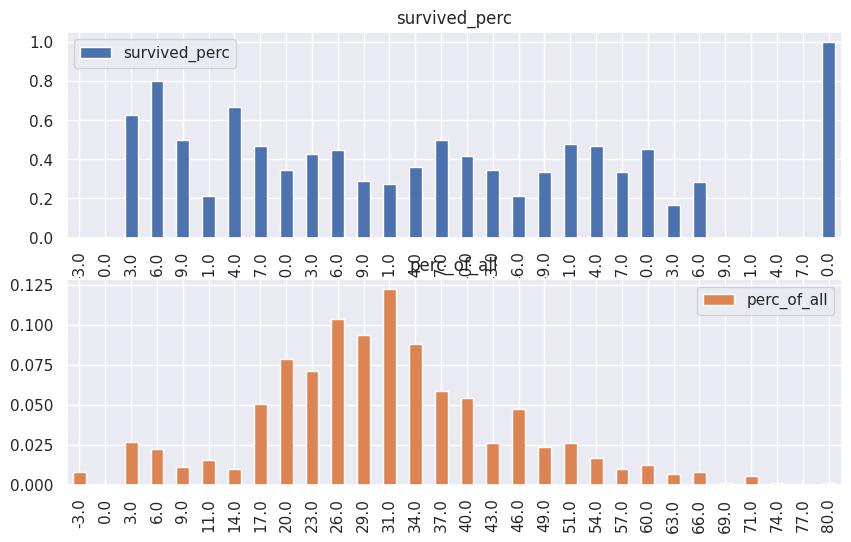

In [106]:
def continious_data_to_bins(column, bins_number):
    df_with_categorical_age, bins_arr = pd.cut(df_all[column], bins_number, retbins=True )
    groupby_age =  df_all.groupby(df_with_categorical_age)
    df_age = groupby_age['Survived'].agg(['mean', 'count'])
    df_age.set_index(np.round(bins_arr[1:]), inplace=True)
    df_age['count'] = df_age['count'] / df_all.shape[0]
    df_age.rename(columns={'mean': 'survived_perc',  'count': 'perc_of_all'}, inplace=True)
    return df_age
df_age = continious_data_to_bins('Age', 30)

df_for_plot = df_age
fig, axes = plt.subplots(2, dpi=100, figsize=(10, 6))
df_age.plot.bar(ax=plt.gca(), subplots=True)

In [ ]:
# check perc_of_all work correctly
df_age['perc_of_all'].sum()

In [16]:
df_all['Age'].mean()


29.64209269662921

Epoch 1/10
3/3 [==============================] - 2s 187ms/step - loss: 0.3249 - accuracy: 0.6040 - val_loss: 0.2469 - val_accuracy: 0.6854
Epoch 2/10
3/3 [==============================] - 0s 77ms/step - loss: 0.2607 - accuracy: 0.6743 - val_loss: 0.5029 - val_accuracy: 0.4129
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 0.3990 - accuracy: 0.5217 - val_loss: 0.2462 - val_accuracy: 0.6966
Epoch 4/10
3/3 [==============================] - 0s 74ms/step - loss: 0.2442 - accuracy: 0.6951 - val_loss: 0.3527 - val_accuracy: 0.5955
Epoch 5/10
3/3 [==============================] - 0s 81ms/step - loss: 0.3022 - accuracy: 0.6479 - val_loss: 0.2519 - val_accuracy: 0.6882
Epoch 6/10
3/3 [==============================] - 0s 62ms/step - loss: 0.2390 - accuracy: 0.6898 - val_loss: 0.3606 - val_accuracy: 0.5899

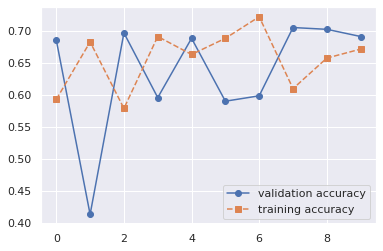

In [95]:
# my stupid and random try to deep learning without knowing anything
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_shape=(10, )))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])


titanic_recognition_model = model.fit(X_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

plt.plot(titanic_recognition_model.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(titanic_recognition_model.history['accuracy'], '--s', label='training accuracy')
plt.legend();
